In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
# !git clone https://github.com/facebookresearch/mae.git
sys.path.append('./mae')

import models_mae

In [2]:
# define the utils

import models_mae

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

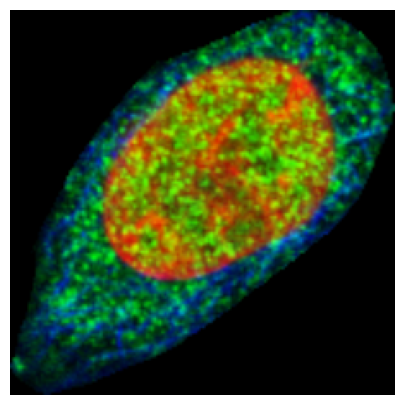

In [3]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img = Image.open(requests.get(img_url, stream=True).raw)

import cv2
img_path = '../preprocessing/train/cell/0be5816c-bbc6-11e8-b2bc-ac1f6b6435d0_cell8.png'
img = cv2.imread(img_path)
img = cv2.resize(img, (224,224))
# img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [4]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:


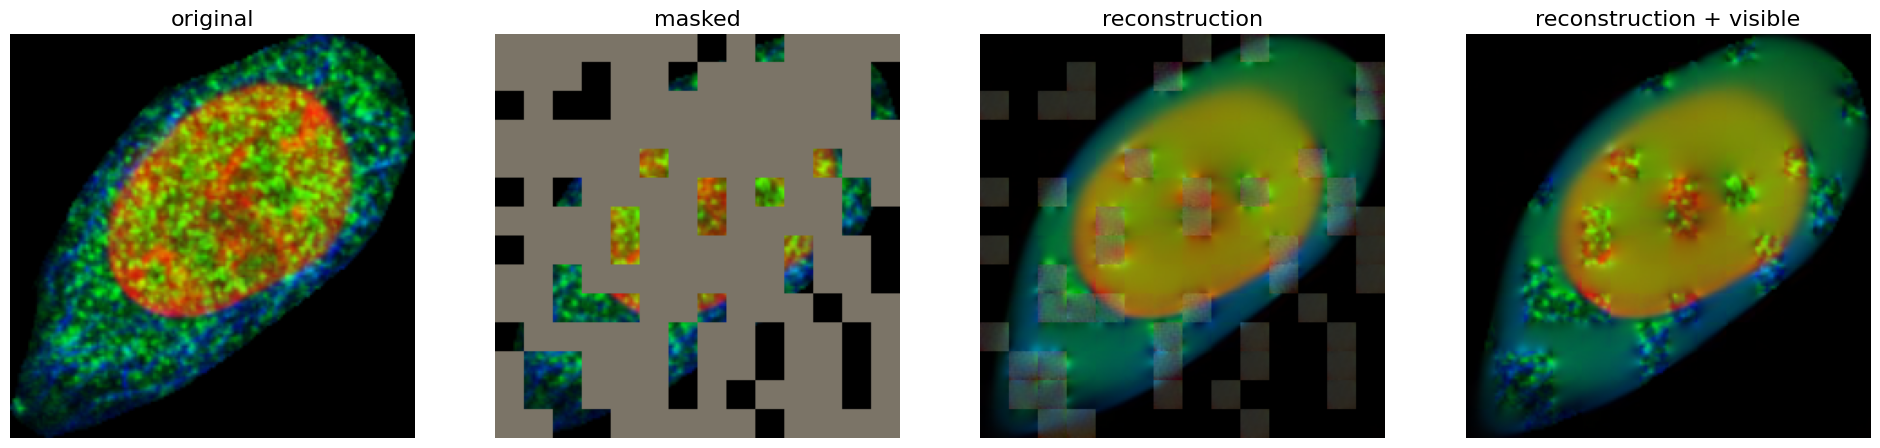

In [5]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

In [50]:
%cd mae
import torch

if torch.cuda.is_available():
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. No GPUs detected.")


[Errno 2] No such file or directory: 'mae'
/projectnb/btec-design3/novanetworks/nova-networks/HPA-nova/mae
Number of available GPUs: 1
GPU 0: Tesla P100-PCIE-12GB


/projectnb/btec-design3/novanetworks/novaenv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [53]:
# Load model, in MAE

# f12: vit_base_patch16
# f13: mae_vit_base_patch16 --> doesn't work!

# model_path = '../results/f11/checkpoints/f0_epoch-9.pth'
# vit_nova = torch.load(model_path)

# apr14_4: SoftTargetCrossEntropy
# apr14_5: BCE, with pos_weights
# apr14_9: BCE, with pos_weights --> 100 epochs
# apr16_2~4: added softmax in last layer (after head), overriding forward function of ViT in models_vit, batch 32
    # https://discuss.pytorch.org/t/add-softmax-layer-to-vision-transformer-model/165656
# apr16_5~6: batch size 64


# Fine-tune model with pretrained MAE
JOB_DIR = '../results/apr16_5'
# MDL = vit_nova
PRETRAIN_CHKPT = '../mae_pretrain_vit_base.pth'
# PRETRAIN_CHKPT = model_path # try, apr11
DATA_DIR = '../../preprocessing/train/cell'

!python submitit_finetune.py \
    --job_dir ${JOB_DIR} \
    --nodes 1 \
    --batch_size 64 \
    --model vit_base_patch16 \
    --finetune ${PRETRAIN_CHKPT} \
    --epochs 100 \
    --blr 5e-4 --layer_decay 0.65 \
    --weight_decay 0.05 --drop_path 0.1 --reprob 0.25 --mixup 0.8 --cutmix 1.0 \
    --dist_eval --data_path ${DATA_DIR}
    # --device cuda

# python submitit_finetune.py \
#     --job_dir ${JOB_DIR} \
#     --nodes 4 \
#     --batch_size 32 \
#     --model vit_base_patch16 \
#     --finetune ${PRETRAIN_CHKPT} \
#     --epochs 100 \
#     --blr 5e-4 --layer_decay 0.65 \
#     --weight_decay 0.05 --drop_path 0.1 --reprob 0.25 --mixup 0.8 --cutmix 1.0 \
#     --dist_eval --data_path ${IMAGENET_DIR}


/projectnb/btec-design3/novanetworks/nova-networks/HPA-nova/mae
Traceback (most recent call last):
  File "/projectnb/btec-design3/novanetworks/nova-networks/HPA-nova/mae/submitit_finetune.py", line 143, in <module>
    main()
  File "/projectnb/btec-design3/novanetworks/nova-networks/HPA-nova/mae/submitit_finetune.py", line 135, in main
    output = job.result()
  File "/projectnb/btec-design3/novanetworks/novaenv/lib/python3.10/site-packages/submitit/core/core.py", line 266, in result
    r = self.results()
  File "/projectnb/btec-design3/novanetworks/novaenv/lib/python3.10/site-packages/submitit/core/core.py", line 289, in results
    outcome, result = self._get_outcome_and_result()
  File "/projectnb/btec-design3/novanetworks/novaenv/lib/python3.10/site-packages/submitit/core/core.py", line 384, in _get_outcome_and_result
    raise utils.UncompletedJobError("\n".join(message))
submitit.core.utils.UncompletedJobError: Job 346041 (task: 0) with path /projectnb/btec-design3/novanetwor

In [36]:
def average_precision(y_true, y_pred):
    """
    Calculate average precision for a single sample.

    Parameters:
        y_true (1D array): True labels.
        y_pred (1D array): Predicted labels.

    Returns:
        float: Average Precision (AP) for the sample.
    """
    num_true = np.sum(y_true)
    if num_true == 0:
        return 0.0

    sorted_indices = np.argsort(y_pred)[::-1]
    precision = 0.0
    num_correct = 0.0

    for i, idx in enumerate(sorted_indices):
        if y_true[idx] == 0.90526316:
            num_correct += 1
            precision += num_correct / (i + 1)
            print("CORRECT!")

    # print("end avg_precision")
    return precision / num_true

y_true = np.array([0.00526316, 0.00526316, 0.00526316, 0.00526316, 0.90526316, 0.00526316,
                   0.00526316, 0.00526316, 0.00526316, 0.00526316, 0.00526316, 0.00526316,
                   0.00526316, 0.00526316, 0.00526316, 0.00526316, 0.00526316, 0.00526316,
                   0.00526316])
y_pred = np.array([0.02155, -0.01447, 0.012215, -0.00771, -0.00783, -0.00581, -0.0185,
                   0.002846, -0.02003, -0.01426, -0.01736, -0.0229, -0.00956, 0.01442,
                   0.007324, -0.02112, 0.0201, -0.02087, -0.02257])
ap = average_precision(y_true, y_pred)

print(ap)

CORRECT!
0.11111110666666683


In [35]:
a = 0.123323
a = round(a,3)
print(a)


0.123


In [ ]:
# Eval

python main_finetune.py --eval --resume mae_finetuned_vit_huge.pth --model vit_huge_patch14 --batch_size 16 --data_path ${IMAGENET_DIR}